# Lecture 12 - Sentiment Analysis

In this notebook we will learn how to measure sentiment in text. 

Below is the overview of this notebook.

0. Install required packages (only need to do this the first time we run the notebook)

1. Load corpus of tweets

2. Load sentiment classifier, which in this case is a BERT transformer

3.  Measure tweet sentiment

4. Analyze sentiment of tweets, compare to retweet counts

5. Visualize UMAP transformer embeddings


Below are some cool blogs you can read to learn more about the BERT transformer.

http://jalammar.github.io/illustrated-bert/

https://towardsdatascience.com/deconstructing-bert-distilling-6-patterns-from-100-million-parameters-b49113672f77

https://github.com/jessevig/bertviz

## Install requirements

The pip command lets you install python packages.  We need 2 packages today.

1) tensorflow - this lets us use neural network models. Instructions for your system are here: https://www.tensorflow.org/install/pip

2) pytorch - this lets us use neural network models with cleaner code.  Instructions for your system are here: https://pytorch.org/get-started/locally/

3) transformers - this lets us use pre-trained transformer models.  Instructions are here: https://huggingface.co/transformers/installation.html

In [1]:
#upgrade pip
!pip install --upgrade pip

#install tensorflow
!pip install --upgrade tensorflow   --user

#install pytorch
!pip install --upgrade torch  --user

#install transformers
!pip install  transformers --user


## Import Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import umap
import scripts.TextAnalysis as ta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import codecs  #this let's us display tweets properly (emojis, etc.)



#### Test code to make sure tensorflow works

In [3]:
import tensorflow as tf
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(1704.8511, shape=(), dtype=float32)


#### Test code to make sure pytorch works

In [4]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.6232, 0.6548, 0.3745],
        [0.1712, 0.7109, 0.6034],
        [0.4438, 0.1991, 0.0076],
        [0.2447, 0.8615, 0.3960],
        [0.7714, 0.3520, 0.0462]])


# Sentiment Classification with BERT

We will pass the tweets through a pre-trained sentiment classifier with a BERT core.  Then we will plot the tweets with UMAP and color them by their sentiment.  Hopefully the positive and negative are in different regions of the plot.

### Download Pre-Traine Model and Tokenizer

We will download the model and tokenizer from https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment.  This is a pre-trained model in the huggingface library that was trained on product reviews in multiple languages.  The output sentiment is between 1 and 5.

There are many other models on huggingface that you can find here: https://huggingface.co/models?pipeline_tag=text-classification.

We will create a tokenizer for the model called `tokenizer` and create the model itself, which we call `model`.  Every model needs its own tokenizer which tells it how to map text into the proper input vectors.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

### Define Sentiment Classifier and Transformer Embedding Function

When we pass text through our transformer model, we get many pieces of data in the output. First, we get the sentiment of the text.  Second, we get the text embedding in the final layer of the transformer.  Remember, inside the transformer we turn the input text into a high dimensional vector. This is the transformer embedding, and it is designed to separate text based on sentiment.


We will create a function called `sentiment_classifier` which takes as input a string `text`, a transformer model called `model`, and a tokenizer called `tokenizer`, and returns the sentiment and embedding of the text.  The raw sentiment output of the model is a probability for each sentiment value.  The function will return the average sentiment based on these probabilities.  


In [6]:
def sentiment_classifier(text,model,tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  #use this line if you want the mean score
    #sentiment = logits.argmax()  #use this line if you just wanted the most likely score
    embedding = output.hidden_states[12].detach().numpy().squeeze()[0]
    return sentiment,embedding


### Sentiment Classification Example
Now we can test the model on some text.  Feel free to try any text you want here.  Just put your text in the list `Text`.

In [7]:
Text = ["This class is kinda boring, but informative", 
        "This class is awesome", 
        "this class is dope", 
        "this class is stupid",
       "this class is crazy hard",
       "this class is fun",
       "this class is fun!",
       "this class is :(",
       "this class is :)",
       "Cat is sick",
       "That dunk was sick!",
       "We were victorious!"]

In [8]:
for text in Text:
    sentiment,embedding = sentiment_classifier(text,model,tokenizer)
    print(f"Sentiment:{sentiment:.2f}\nText: {text}\n")

Sentiment:3.12
Text: This class is kinda boring, but informative

Sentiment:4.84
Text: This class is awesome

Sentiment:2.77
Text: this class is dope

Sentiment:1.24
Text: this class is stupid

Sentiment:2.92
Text: this class is crazy hard

Sentiment:4.26
Text: this class is fun

Sentiment:4.44
Text: this class is fun!

Sentiment:3.57
Text: this class is :(

Sentiment:4.29
Text: this class is :)

Sentiment:1.97
Text: Cat is sick

Sentiment:1.91
Text: That dunk was sick!

Sentiment:4.03
Text: We were victorious!



### Load Tweets 

Load the tweets from the file `"data/tweets_lec_10.csv"` into a dataframe `df`.  

In [9]:
df = pd.read_csv("data/tweets_lec_10.csv")
df = df[['screen_name','text','retweet_count']]
df = df
ntweets = len(df)
print(f"dataframe has {ntweets} tweets")
df.head()

dataframe has 19383 tweets


,screen_name,text,retweet_count
0,elonmusk,@Teslarati SpaceX in south Texas &amp; Tesla i...,1404
1,elonmusk,@someone3201 @ERCOT_ISO Yes,208
2,elonmusk,.@ERCOT_ISO is not earning that R,8091
3,elonmusk,@MattWallace888 @vladtenev @RobinhoodApp You\u...,1559
4,elonmusk,"@Tesla Covered in snow &amp; ice, roads mostly...",1430


### Calculate Sentiment and Transformer Embedding of Tweets

We use a for loop iterating over the rows in `df` to calculate the sentiment and transformer embedding of each tweet.  We store the sentiment in the list `Sentiment` and embeddings in the list `Embedding`.  We then add the sentiment to a column in `df` and save the resulting dataframe to a file `"data/lec_12_tweets_sentiment_embedding.csv"`.  This may take a long time on your machine unless you have a GPU.



In [10]:
%%time
c = 0
Sentiment = []
Embedding = []
for index,row in df.iterrows():
    c+=1
    if c%1000==0:print(f"Tweet {c}/{len(df)}")
    sentiment,embedding = sentiment_classifier(row.text,model,tokenizer)
    Sentiment.append(sentiment)
    Embedding.append(embedding)
df['sentiment'] = Sentiment
df.to_csv("data/lec_12_tweets_sentiment_embedding_v1.csv")
df.head()
    

Tweet 1000/19383
Tweet 2000/19383
Tweet 3000/19383
Tweet 4000/19383
Tweet 5000/19383
Tweet 6000/19383
Tweet 7000/19383
Tweet 8000/19383
Tweet 9000/19383
Tweet 10000/19383
Tweet 11000/19383
Tweet 12000/19383
Tweet 13000/19383
Tweet 14000/19383
Tweet 15000/19383
Tweet 16000/19383
Tweet 17000/19383
Tweet 18000/19383
Tweet 19000/19383
Wall time: 50min 50s


,screen_name,text,retweet_count,sentiment
0,elonmusk,@Teslarati SpaceX in south Texas &amp; Tesla i...,1404,3.535395
1,elonmusk,@someone3201 @ERCOT_ISO Yes,208,2.841279
2,elonmusk,.@ERCOT_ISO is not earning that R,8091,1.694170
3,elonmusk,@MattWallace888 @vladtenev @RobinhoodApp You\u...,1559,2.935604
4,elonmusk,"@Tesla Covered in snow &amp; ice, roads mostly...",1430,1.583284


### UMAP Transformer Embedding of Tweets

The tranformer turns the input text into a high dimensional vector.  This is the transformer embedding, and it is designed to separate text based on sentiment.  However, we can't really visualize such a high-dimensional object.  But no worries, UMAP will let us embed this high-dimensional vector into 2 dimensions. 

We apply UMAP to the transformer embedding `Embedding` to create the UMAP transformer embedding `umap_bert_embedding`.  Before doing this we have to convert `Embedding` from a list to an array.  Then we save the UMAP embedding values in `df` as `"umap_transformer_x"` and `"umap_transformer_y"`.  The dataframe is saved to the file `"data/lec_12_tweets_sentiment_embedding.csv"`.



In [11]:
Embedding = np.array(Embedding)
umap_bert_embedding = umap.UMAP(n_components=2, metric='cosine').fit_transform(Embedding)
df['umap_transformer_x'] = umap_bert_embedding[:,0]
df['umap_transformer_y'] = umap_bert_embedding[:,1]
df.to_csv("data/lec_12_tweets_sentiment_embedding_v1.csv")


# Analyze Tweet Sentiment

### Load Tweets and Sentiment

Once we save the tweet sentiments, the next time we run the notebook we can just load this data instead of recalculating the sentiment.  The sentiment is in the file `"data/lec_12_tweets_sentiment_embedding.csv"`.

In [12]:
df = pd.read_csv("data/lec_12_tweets_sentiment_embedding.csv")

### Average User Sentiment

We make a bar plot of the average sentiment of each user.  We do this by grouping `df` by `"screen_name"` and then taking the mean of each group with the `mean` function.  We save this a new dataframe `df_plot` and then use the `barplot` function to make the bar plot.

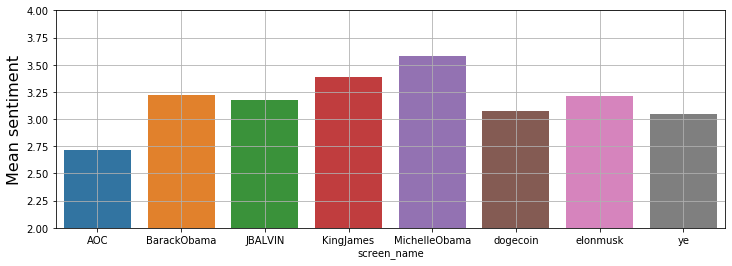

In [13]:
df_plot = df.groupby(by=["screen_name"]).mean()
df_plot['screen_name'] = df_plot.index
df_plot.head()

fig = plt.figure(figsize = (12,4))
sns.barplot(data = df_plot, y= 'sentiment',x = 'screen_name' )
plt.ylim([2,4])
plt.ylabel("Mean sentiment",fontsize = 16)
plt.grid()

### Sentiment Distribution per User

We can make histograms of the tweet sentiment for each user.  We use a for loop to iterate through each screen name.
We use the `histplot` function to make a histogram of the tweets of each user.  We also add a title to each plot so we know whose tweets they are.

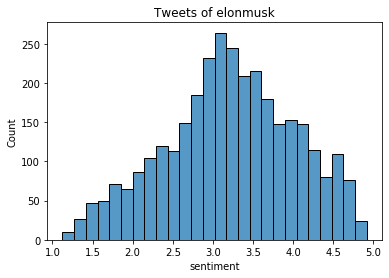

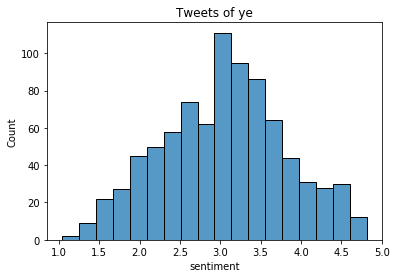

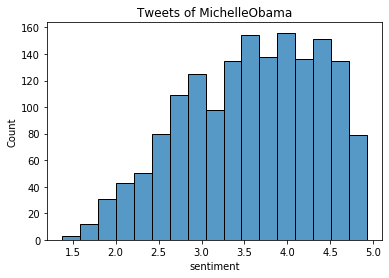

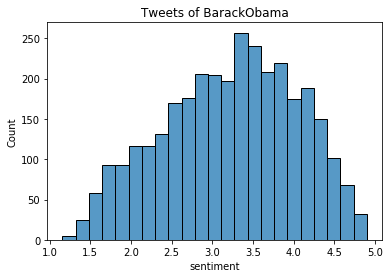

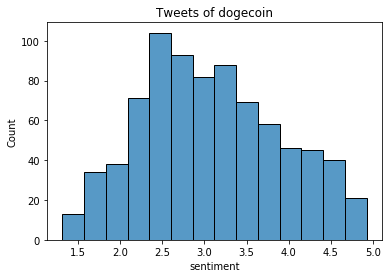

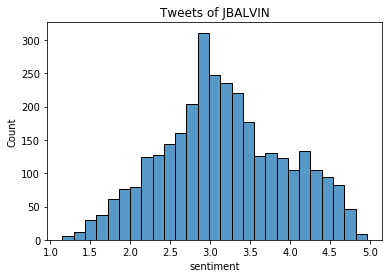

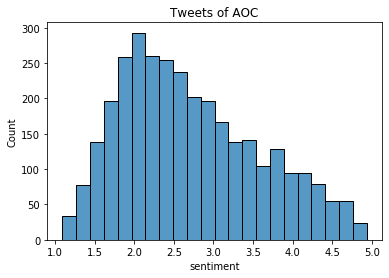

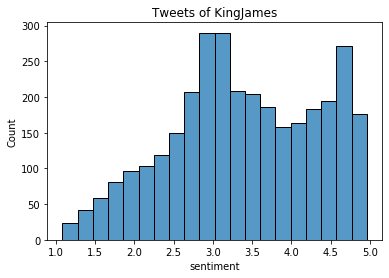

In [14]:
for screen_name in df.screen_name.unique():
    df_plot = df[df.screen_name==screen_name]
    sns.histplot(data=df_plot, x = "sentiment")
    plt.title(f"Tweets of {screen_name}")
    plt.show()

### Look at Tweets with Extreme Sentiment

We can select tweets of each user with very high or very low sentiment and print them out.  We do this by keeping the rows of `df` with the corresponding screen name, and then using `sort_values` to sort the user's tweets by sentiment.  We set `ascending = True` inside the `for` loop to get the most postive tweets, and set `ascending = False` to get the most negative tweets.  We set `ndisplay` equal to the number of tweets we want to print per user.

To show all the funny Twitter characters, we need to use the `decode` function in the `codecs` module.



In [15]:
ndisplay = 3
print(f"Top {ndisplay} Most Positive Tweets per Screen Name")
for screen_name in df.screen_name.unique():
    df_display = df[(df.screen_name==screen_name)].sort_values(by = ['sentiment'], ascending = False)
    c=0
    print(f"\n{screen_name}")
    for index,row in df_display.iterrows():
        c+=1
        text = codecs.decode(row.text, 'unicode_escape')
        print(f"\tsentiment = {row.sentiment:.2f}: {text}")
        if c>=ndisplay:break

print("".join('-' * 200))
print(f"Top {ndisplay} Most Negative Tweets per Screen Name")
for screen_name in df.screen_name.unique():
    df_display = df[(df.screen_name==screen_name)].sort_values(by = ['sentiment'], ascending = True)
    c=0
    print(f"\n{screen_name}")
    for index,row in df_display.iterrows():
        c+=1
        text = codecs.decode(row.text, 'unicode_escape')
        print(f"\tsentiment = {row.sentiment:.2f}: {text}")
        if c>=ndisplay:break



Top 3 Most Positive Tweets per Screen Name

elonmusk
	sentiment = 4.92: Such a privilege to work with people I like &amp; respect so much. I feel blessed. 
	sentiment = 4.91: One of the all-time best songs https://t.co/IvI7IOgMAa 
	sentiment = 4.91: @lrocket Thanks for everything you did to help build SpaceX! Some of the best memories ever. 

ye
	sentiment = 4.81: @m0E_tv my PC and I are very happy thank you 
	sentiment = 4.81: Thank you @BeddyFPS for optimizing my pc! Quick and efficient service 
	sentiment = 4.78: @briannasaurus I love you Brianna!! 

MichelleObama
	sentiment = 4.92: Happy 20th anniversary, Barack. Thank you for being an incredible partner, friend, and father every day. I love you! –mo 
	sentiment = 4.92: One of my greatest joys as First Lady was getting to meet so many incredible young people from across the country.… https://t.co/h3Q3vadmWE 
	sentiment = 4.92: So incredibly proud of these students! Everyone at @IPROMISESchool—teachers, staff, and of course those in

### Correlation of Sentiment and Retweet Count

Do extreme tweets get more engagement?  We can look at the correlation of the sentiment absolute value and retweet count to see.  We create a column `"sentiment_abs"` which is the absolute value of the `"sentiment"` column minus the mean opinion.  We get the absolute value using the `abs` function.  The we calculate the correlation matrix `df_corr` with the `corr` function.  Finally, we make a heatmap using the `heatmap` function.

,Unnamed: 0,Unnamed: 0.1,retweet_count,sentiment,sentiment_abs,star,umap_transformer_x,umap_transformer_y
Unnamed: 0,1.000000,1.000000,0.130114,-0.046971,0.065328,-0.048372,-0.122884,-0.049606
Unnamed: 0.1,1.000000,1.000000,0.130114,-0.046971,0.065328,-0.048372,-0.122884,-0.049606
retweet_count,0.130114,0.130114,1.000000,-0.031909,0.116830,-0.029368,0.171868,-0.062101
sentiment,-0.046971,-0.046971,-0.031909,1.000000,0.001981,0.837889,0.105563,0.748351
sentiment_abs,0.065328,0.065328,0.116830,0.001981,1.000000,0.059077,0.072005,0.020327
star,-0.048372,-0.048372,-0.029368,0.837889,0.059077,1.000000,0.121321,0.740243
umap_transformer_x,-0.122884,-0.122884,0.171868,0.105563,0.072005,0.121321,1.000000,0.054864
umap_transformer_y,-0.049606,-0.049606,-0.062101,0.748351,0.020327,0.740243,0.054864,1.000000


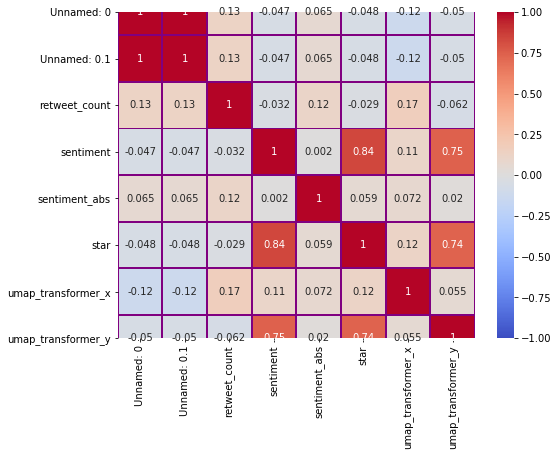

In [16]:
df['sentiment_abs'] = (df.sentiment-df.sentiment.mean()).abs()
df_corr = df.corr(method = 'kendall')
fig = plt.figure(figsize=(8,6))
sns.heatmap(df_corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='purple')
df_corr

### Box Plot of Retweet Count vs Sentiment

To see this correlation of extreme sentiment and retweet count, we can make a box plot. The box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.  More details on the `boxplot` function can be found here: https://seaborn.pydata.org/generated/seaborn.boxplot.html

 We first create a column called `star` that rounds the sentiment to the nearest integer.  Then we can make a boxplot of the retweet count versus the tweet star sentiment.  We will have to limit the y-axis in order to see the pattern clearly.  We set the maximum value on the y-axis equal to `ymax`, which we set to be an upper quantile of the retweet count.

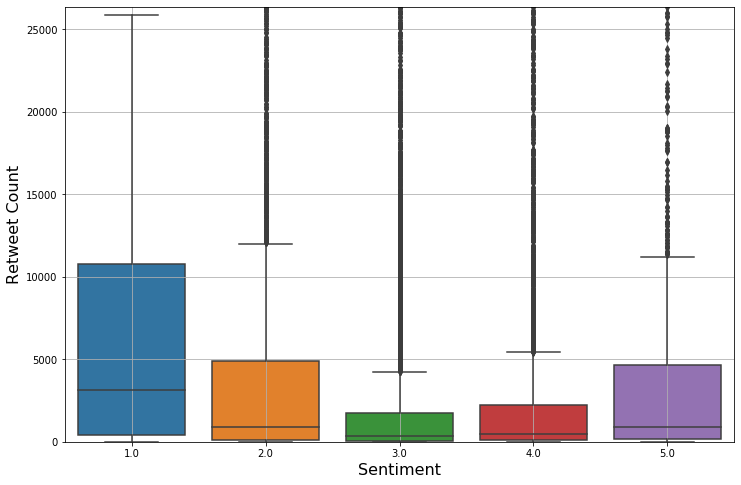

In [17]:
df['star'] = df.sentiment.round()

fig = plt.figure(figsize = (12,8))
ax = sns.boxplot(data=df, x="star", y="retweet_count")
ymax = df.retweet_count.quantile(0.95)
plt.ylim([0,ymax])
plt.xlabel("Sentiment", fontsize = 16)
plt.ylabel("Retweet Count", fontsize = 16)
plt.grid()
plt.show()

### Box Plot per User

We can also look at a boxplot for each individual user.  

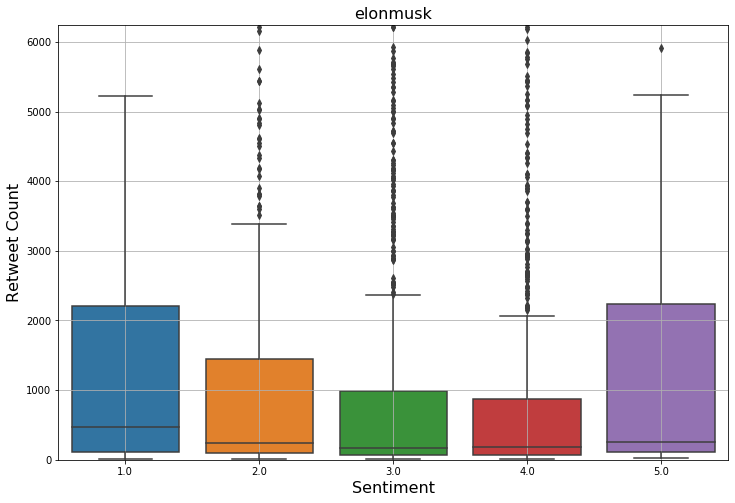

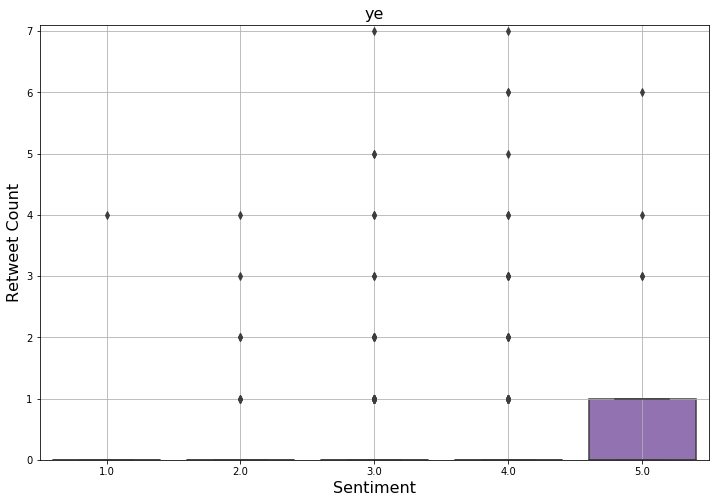

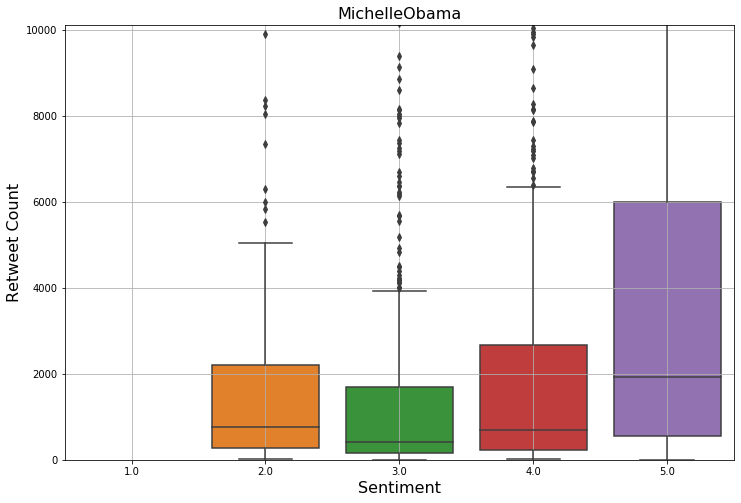

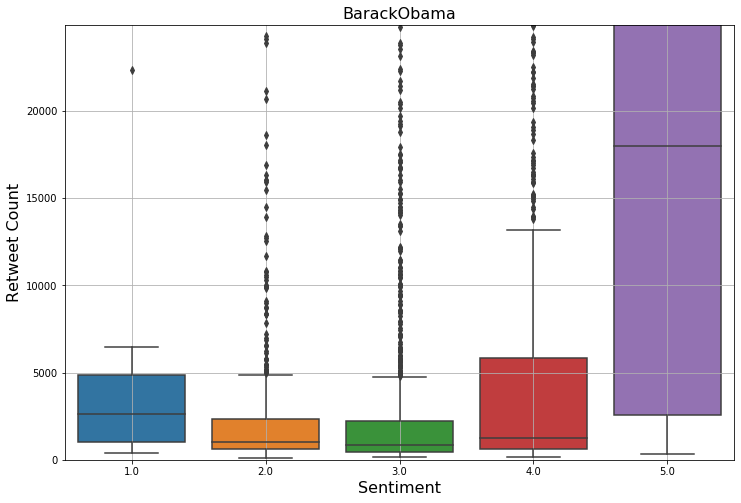

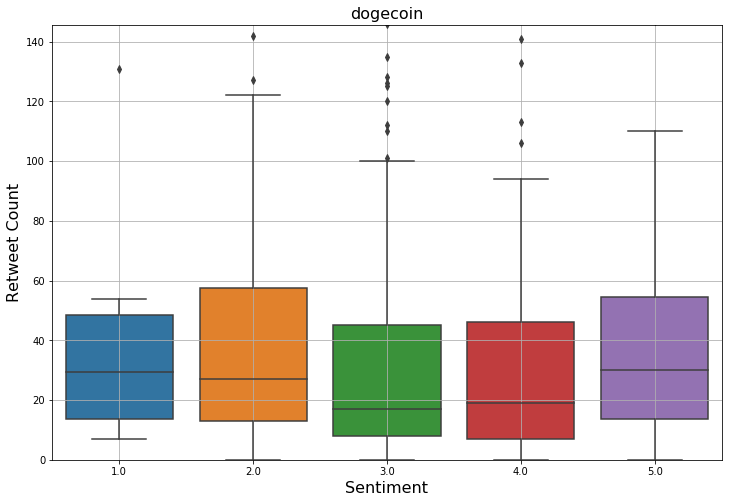

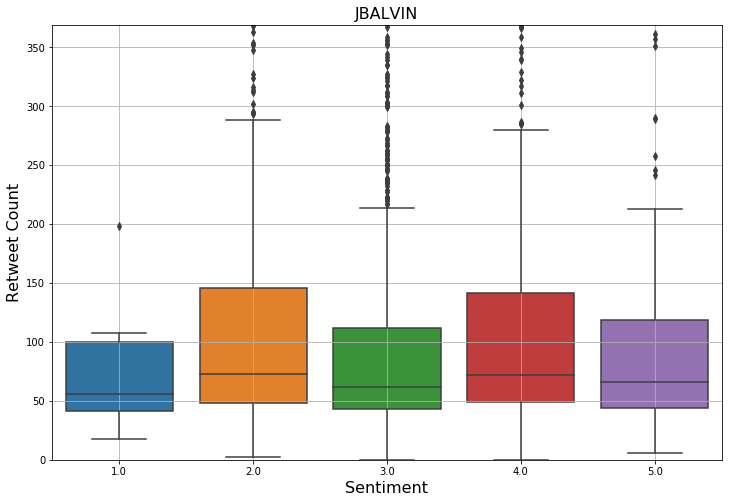

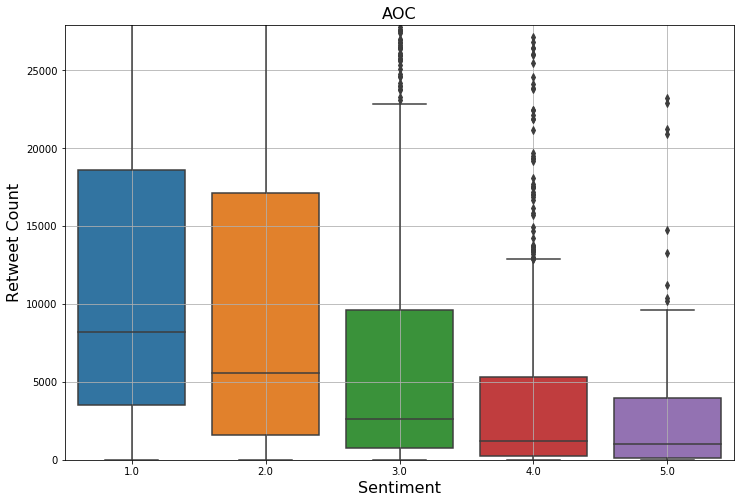

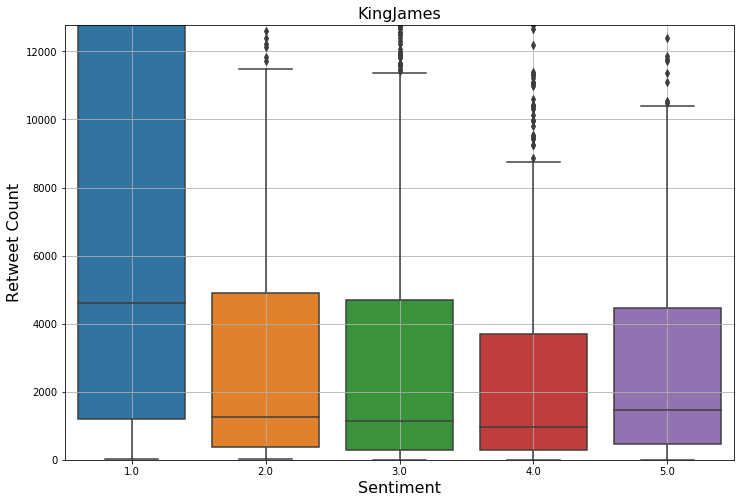

In [18]:
for screen_name in df.screen_name.unique():
    fig = plt.figure(figsize = (12,8))
    df_plot = df[df.screen_name==screen_name]
    ax = sns.boxplot(data=df_plot, x="star", y="retweet_count")
    ymax = df_plot.retweet_count.quantile(q=0.9)
    plt.ylim([0,ymax])
    plt.xlabel("Sentiment", fontsize = 16)
    plt.ylabel("Retweet Count", fontsize = 16)
    plt.title(f"{screen_name}", fontsize = 16)
    plt.grid()
    plt.show()

# Visualize Transformer Embedding

Now we will visulize the transformer embeddings using UMAP to see how the sentiment is distributed.

### Load Tweet+Sentiment+Embedding Dataframe 

To save time, we can just load the tweet, sentiment, and embedding data into a dataframe `df`.

In [19]:
df = pd.read_csv("data/lec_12_tweets_sentiment_embedding.csv")

### Scatter Plot of UMAP Transformer Tweet Embeddings

We can make a scatter plot of the UMAP transformer embeddings of the tweets.  We will color the data points by the user screen name.  We will also make another plot next to this plot where we color the data points by sentiment.  You set the column for the datapoint color with the `hue` parameter.  You can choose a color palette with the `palette` parameter.  There are many palettes you can choose from, but for discrete values like `"screen_name"` use the `"bright"` palette and for continous values like `"sentiment"` use the `"vlag"` palette.  Of course feel free to try other palettes. A complete list can be found here: https://seaborn.pydata.org/tutorial/color_palettes.html


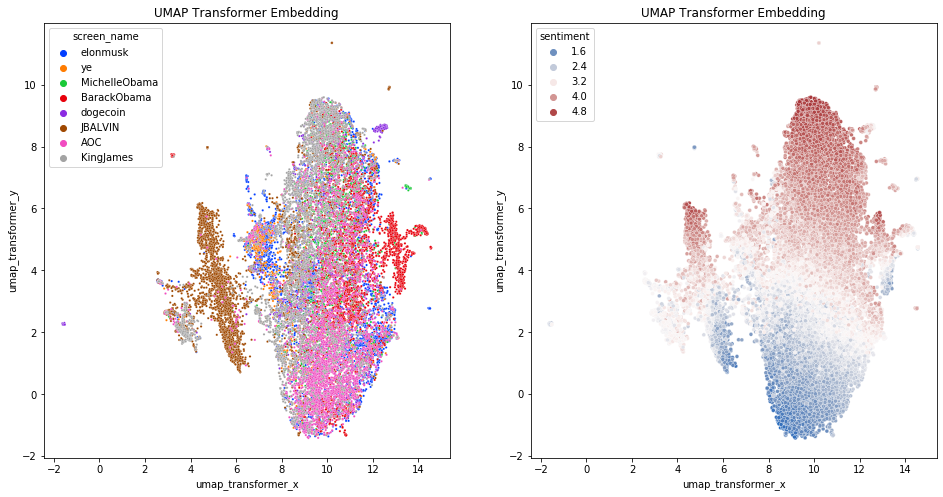

In [20]:
fig = plt.figure(figsize = (16,8))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(data=df, x="umap_transformer_x", y="umap_transformer_y", hue="screen_name", palette="bright", s=5)
plt.title("UMAP Transformer Embedding")

ax2 = plt.subplot(1,2,2)
sns.scatterplot(data=df, x="umap_transformer_x", y="umap_transformer_y", hue="sentiment", 
               palette="vlag", s=15)
plt.title(f"UMAP Transformer Embedding")
plt.show()

### Scatter Plot of Transformer UMAP Tweet Embeddings Per Screen Name: Color By Sentiment

We can make a seperate scatter plot of the transformer UMAP embeddings of the tweets for each screen name.  We will color the data points by the tweet sentiment. Notice where the positive and negative sentiment tweets are located.

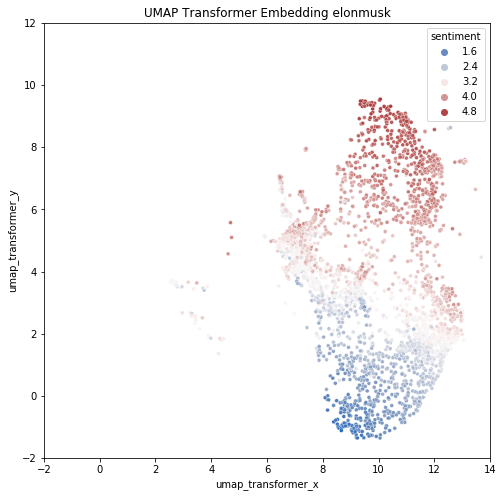

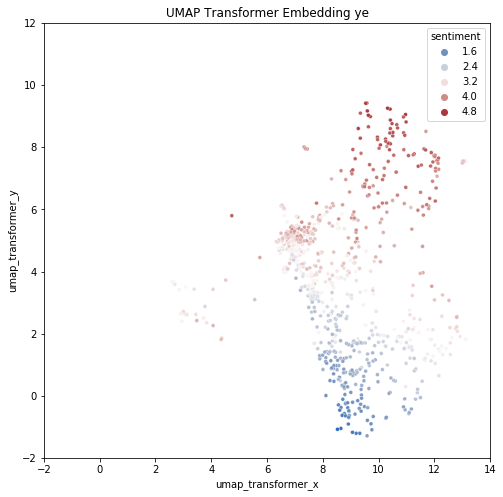

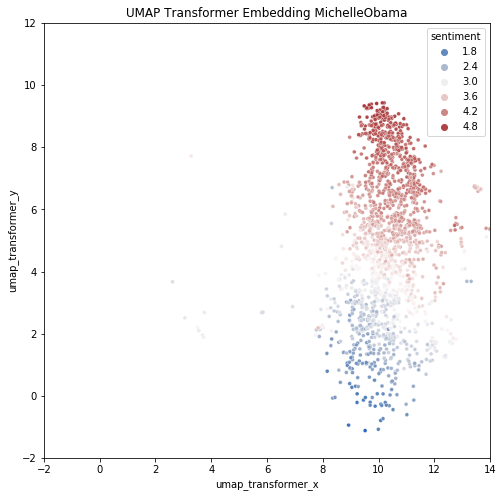

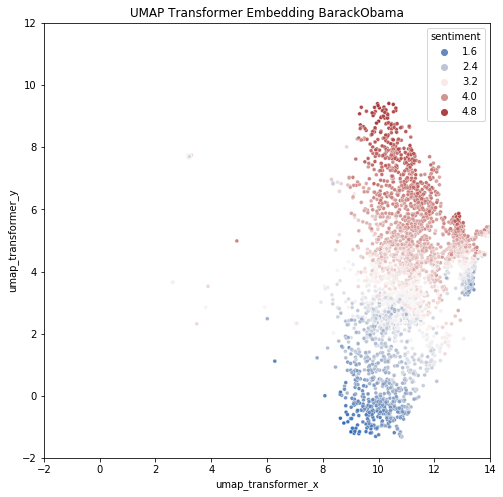

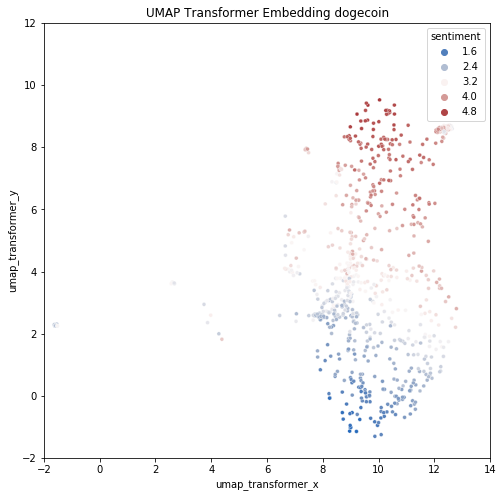

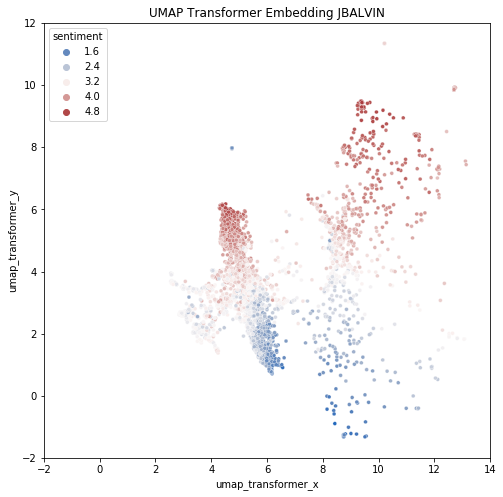

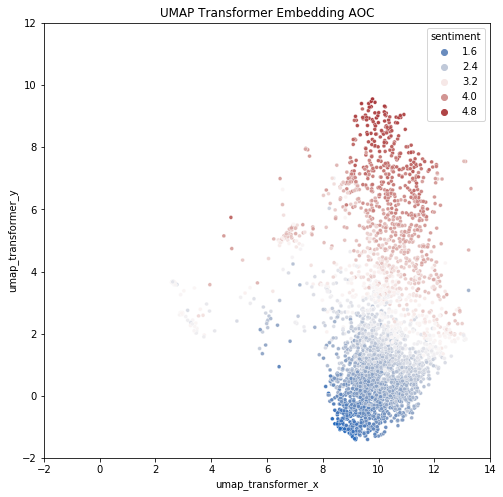

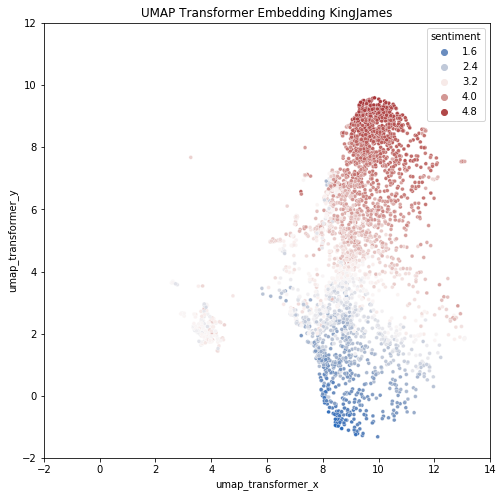

In [21]:
for screen_name in df.screen_name.unique():
    fig = plt.figure(figsize = (8,8))
    ax1 = plt.subplot(1,1,1)
    sns.scatterplot(data=df[df.screen_name==screen_name], x="umap_transformer_x", y="umap_transformer_y", hue="sentiment", 
                    s=15, palette="vlag")
    plt.title(f"UMAP Transformer Embedding {screen_name}")
    plt.xlim([-2,14])
    plt.ylim([-2,12])
    plt.show()

# Bonus:  Try another huggingface model

If we have time in lecture, let's try to use another huggingface model